# Predicting Movie Success

In [68]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import data_processing.load_sqlite as load_sql
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.tree import plot_tree

## Defining Success

In this project we are using movie data obtained from The Movie Database (TMDB). This site provides a *vote average* (from 0 to 10) for each movie that we use to determine whether or not a movie was successful. More precisely, **we define a movie to be successfull if it has a vote average above 7.0**.  

## Fetching Movie Data

In [2]:
df = load_sql.fetch_movie_rating_features()
df.head()

,movie_id,vote_average,title,release_date,runtime,vote_count,top_cast_id,top_2_cast_ids,top_5_cast_ids,num_cast_members,director_ids,writer_ids,company_ids,genre_ids
0,2,7.113,Ariel,1988-10-21,73,341,None,None,None,0,None,None,2303,"18,35,80,10749"
1,3,7.300,Shadows in Paradise,1986-10-17,74,404,None,None,None,0,None,None,2303,"18,35,10749"
2,5,5.858,Four Rooms,1995-12-09,98,2674,3129,"3129,3130","3129,3130,3131,3124,2555",28,"138,2294,3110,3111","138,2294,3110,3111","14,59","35,80"
3,6,6.500,Judgment Night,1993-10-15,109,345,2880,"2880,9777","2880,9777,5724,10822,12799",31,2042,"52035,52035,1088307","33,182,1644","28,53,80"
4,11,8.200,Star Wars,1977-05-25,121,20915,2,"2,3","2,3,4,5,12248",104,1,1,"1,25","12,28,878"


## Pre-split Processing

In [3]:
def pre_split_processing(df):
    """
    Perform pre-split processing on the movie data.

    - Drop rows with missing values.
    - Convert 'release_date' to Unix timestamp (seconds).
    - Create a 'successful' column where success is defined by vote_average > 7.0.
    """
    df = df.dropna().copy()
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['release_date'] = df['release_date'].astype(int) / 10**9
    df['successful'] = (df['vote_average'] > 7.0).astype(int)

    return df

In [4]:
df = pre_split_processing(df)
df.head()

,movie_id,vote_average,title,release_date,runtime,vote_count,top_cast_id,top_2_cast_ids,top_5_cast_ids,num_cast_members,director_ids,writer_ids,company_ids,genre_ids,successful
2,5,5.858,Four Rooms,8.184672e+08,98,2674,3129,"3129,3130","3129,3130,3131,3124,2555",28,"138,2294,3110,3111","138,2294,3110,3111","14,59","35,80",0
3,6,6.500,Judgment Night,7.506432e+08,109,345,2880,"2880,9777","2880,9777,5724,10822,12799",31,2042,"52035,52035,1088307","33,182,1644","28,53,80",0
4,11,8.200,Star Wars,2.333664e+08,121,20915,2,"2,3","2,3,4,5,12248",104,1,1,"1,25","12,28,878",1
5,12,7.817,Finding Nemo,1.054253e+09,100,19486,13,"13,14","13,14,12,5293,118",68,"7,8","7,7,10,11,32535,1236458,1994647,2004922,2216342",3,"16,10751",1
6,13,8.468,Forrest Gump,7.723296e+08,142,27890,31,"31,32","31,32,33,35,34",176,24,"26,27","4,412,21920","18,35,10749",1


In [5]:
print(f"The proportion of movies that are successful: {df['successful'].mean()}")

The proportion of movies that are successful: 0.2013433063654404


## Preparing the Data with Frequency Encoding

First, we split the dataset into training and testing sets to avoid data leakage during the frequency encoding process.

In [34]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Train set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 20963
Test set size: 5241


We wrap the logic of frequency encoding into a function since we will use it later:

In [35]:
def add_frequency_encoding(train_df, test_df, categorical_cols, default_freq=1):
    """
    Adds frequency-encoded versions of the categorical columns to both train and test dataframes.

    Parameters:
        train_df (pd.DataFrame): Training dataframe.
        test_df (pd.DataFrame): Test dataframe.
        categorical_cols (list): List of categorical column names.
        default_freq (int): Frequency to assign to unseen values in test data.

    Returns:
        train_df, test_df (pd.DataFrames): Updated dataframes with frequency-encoded columns.
    """
    for col in categorical_cols:
        freq_map = train_df[col].value_counts().to_dict()
        
        train_df[col + '_freq'] = train_df[col].map(freq_map).fillna(default_freq)
        test_df[col + '_freq'] = test_df[col].map(freq_map).fillna(default_freq)
    
    return train_df, test_df

Now we specify the categorical features to use, and apply frequency encoding:

In [36]:
categorical_cols = ['company_ids', 'top_cast_id', 'top_2_cast_ids', 'top_5_cast_ids', 'director_ids', 'writer_ids', 'genre_ids']
train_df, test_df = add_frequency_encoding(train_df, test_df, categorical_cols)

The last thing to do before training the random forest model is to remove the non-numerical columns and split the data into the appropriate features and target. Again, we wrap this in a function for later use.

In [37]:
def prepare_features(df, target_col="successful", drop_cols=["vote_average", "vote_count", "successful", "movie_id"]):
    """
    Selects numeric features for modeling, excluding specified columns.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        target_col (str): Name of the target column.
        drop_cols (list): Columns to drop from features.

    Returns:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target vector.
    """
    features_to_keep = df.select_dtypes(include=["float64", "int64"]).columns
    X = df[features_to_keep].drop(columns=drop_cols)
    y = df[target_col]
    return X, y

Applying this function to the training and testing datasets is the final preprocessing step:

In [38]:
X_train, y_train = prepare_features(train_df)
X_test, y_test = prepare_features(test_df)

## Making the Model: A Random Forest Classifier

Now that the data is properly preprocessed, we are ready to create the random forest model. 

In [39]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10, 
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    bootstrap=True,
    oob_score=True,
    random_state=42
)

rf.fit(X_train, y_train)

print("Training score:", rf.score(X_train, y_train))
print("Testing score:", rf.score(X_test, y_test))

Training score: 0.8241186853026762
Testing score: 0.8061438656744896


## Evaluating the Model

In [89]:
pred = rf.predict(X_test)

print(f"Total number of movies in test set: {len(X_test)}")
print(f"Total number of successful movies in test set: {y_test.sum()}")
print(f"Number of movies in test set predicted successful: {pred.sum()}")
print(f"Proportion of movies in test set predicted successful: {pred.sum()/len(X_test): .4f}")

Total number of movies in test set: 5241
Total number of successful movies in test set: 1038
Number of movies in test set predicted successful: 128
Proportion of movies in test set predicted successful:  0.0244


Relative to the actual number of successful movies, the model is not predicting that very many successes. Let's check on the model's precision and recall:

In [82]:
print(f"Precision: {precision_score(y_test, pred): .2f} (probability that a predicted success is actually successful)")
print(f"Recall:    {recall_score(y_test, pred): .2f} (probability that an actual success is predicted successful)")

Precision:  0.59 (probability that a predicted success is actually successful)
Recall:     0.07 (probability that an actual success is predicted successful)


The recall is quite low, which is just restating that the model is not predicting many successes (relative to the true number of successes). On the other hand, the precision shows that when the model predicts a movie to be a success there is about a 60% chance of that movie being successful. While this is not a super high hit rate, it indicates that the model may be useful. 

## Understanding the Model

To provide insight into how the model works, we first visualize a single decision tree from the random forest ensemble. Since a full tree is too large to follow in detail, we only show the first few levels of decisions. While this certainly does not give us a full understanding of the model, it does this gives a sense of the types of decisions the model makes. 

Later, to get a more global understanding of how the forest is making decisions, we will take a look at the feature importance over all the trees in the forest. First, let's look at some of the trees.

### Visualizing Trees

The following function allows use to see various trees from our random forest model:

In [12]:
def plot_random_forest_tree(rf_model, feature_names, tree_index=0, max_depth=None, class_names=["Not Successful", "Successful"], figsize=(20, 10)):
    """
    Plots a decision tree from a trained Random Forest model.
    
    Parameters:
    - rf_model: The trained RandomForestClassifier object.
    - feature_names: A list of feature names used in training.
    - tree_index: Index of the tree within the random forest to visualize.
    - max_depth: Limits the depth of the tree displayed (None = full tree).
    - class_names: Labels for the target classes.
    - figsize: Size of the figure.
    """
    if tree_index >= len(rf_model.estimators_):
        raise ValueError(f"Tree index {tree_index} is out of bounds for the forest with {len(rf_model.estimators_)} trees.")
    
    estimator = rf_model.estimators_[tree_index]
    
    plt.figure(figsize=figsize)
    plot_tree(estimator, 
              max_depth=max_depth, 
              filled=True, 
              feature_names=feature_names, 
              class_names=class_names,
              rounded=True,
              fontsize=10)
    plt.title(f"Decision Tree {tree_index} from Random Forest (Depth: {max_depth})")
    plt.show()

Let's use the function to see the top of a couple trees:

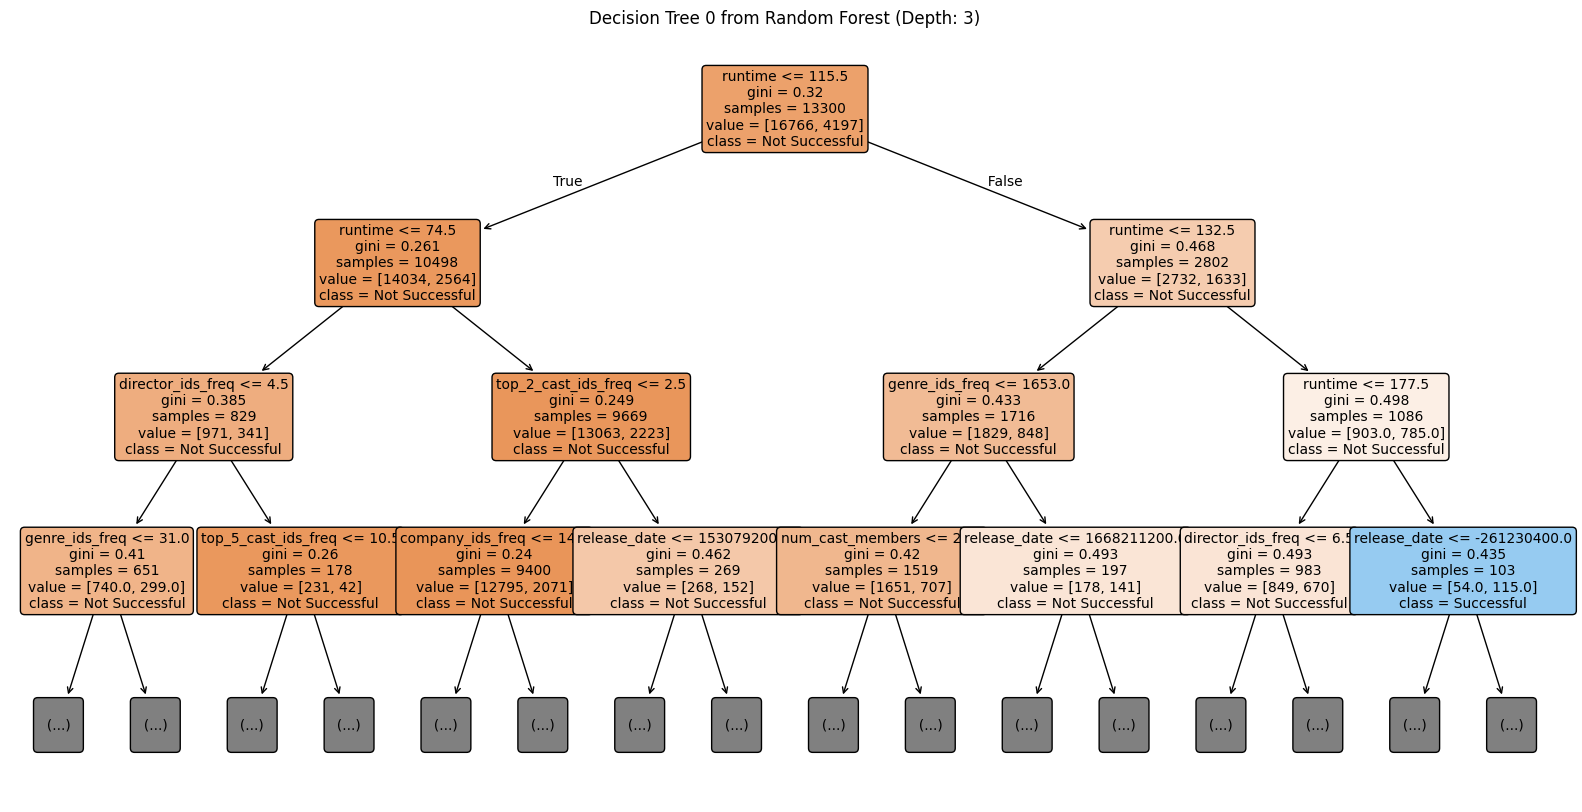

In [13]:
plot_random_forest_tree(rf, feature_names=X_train.columns, tree_index=0, max_depth=3)

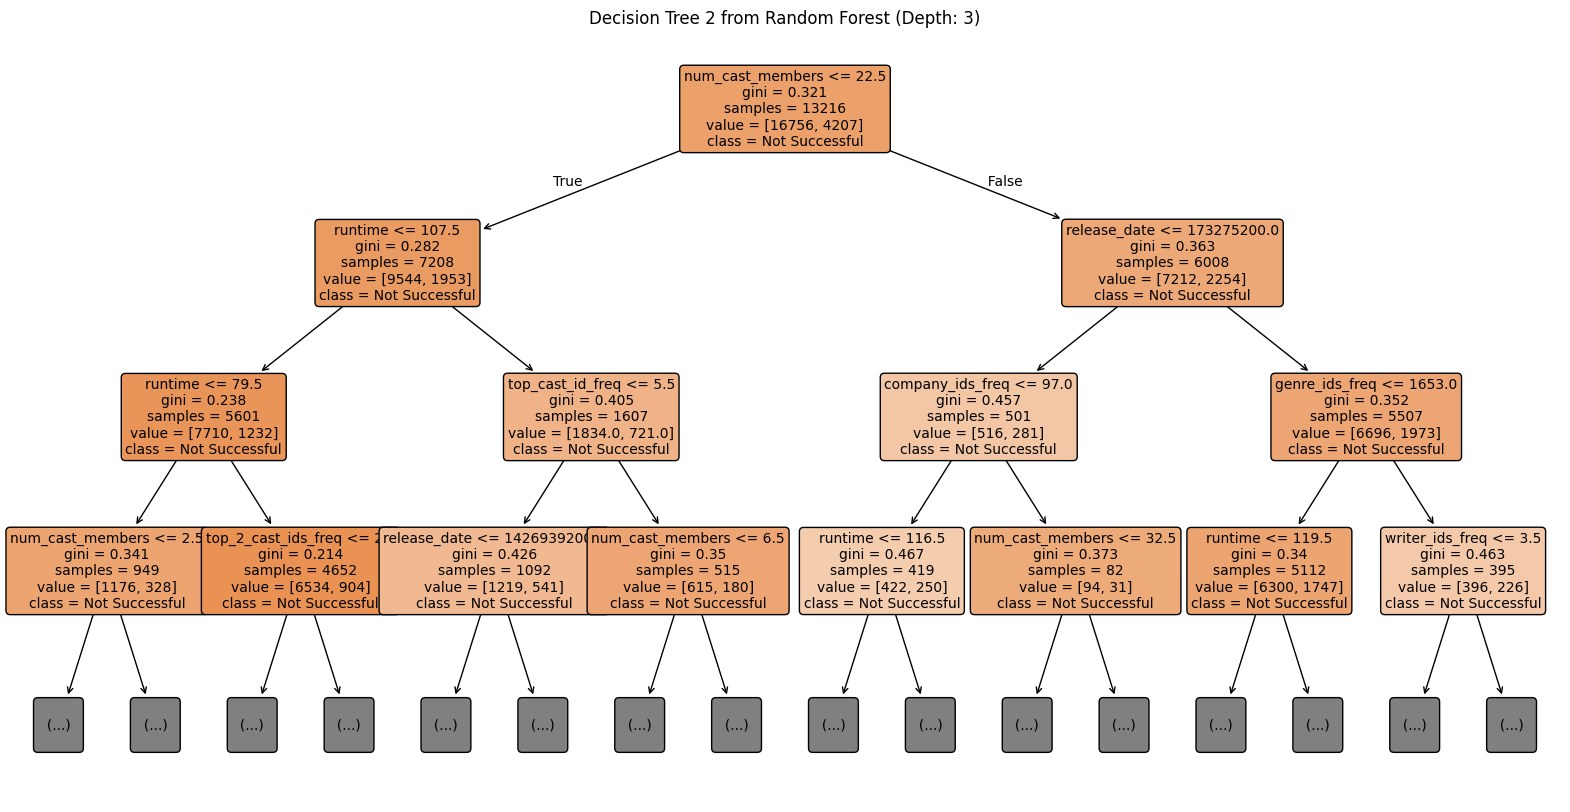

In [14]:
plot_random_forest_tree(rf, feature_names=X_train.columns, tree_index=2, max_depth=3)

### Feature Importance

Next, we examine the feature importance scores, which quantify how much each variable contributed to the final predictions across all trees in the forest. The following function will give us these importance scores in a convinient format:

In [15]:
def get_feature_importance_df(rf_model, feature_names, top_n=None):
    """
    Returns a DataFrame of feature importances sorted by importance.

    Parameters:
    - rf_model: Trained RandomForestClassifier
    - feature_names: List or Index of feature names
    - top_n: Optional integer to limit the number of features returned

    Returns:
    - pandas DataFrame with 'Feature' and 'Importance' columns
    """
    importances = rf_model.feature_importances_
    df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    if top_n is not None:
        df = df.head(top_n)

    return df

Let's see what the most important features are for the random forest model:

In [16]:
get_feature_importance_df(rf, X_train.columns).head()

,Feature,Importance
1,runtime,0.371590
0,release_date,0.142295
2,num_cast_members,0.125859
9,genre_ids_freq,0.121040
4,top_cast_id_freq,0.062538


We can visualize these importance scores nicely with a bar chart:

In [17]:
def plot_feature_importance(rf_model, feature_names, top_n=None):
    """
    Plots the feature importances as a bar chart.

    Parameters:
    - rf_model: Trained RandomForestClassifier
    - feature_names: List or Index of feature names
    - top_n: Optional integer to limit to top N features

    Returns:
    - matplotlib Figure object (not shown automatically)
    """
    df = get_feature_importance_df(rf_model, feature_names, top_n=top_n)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(
        x="Importance", 
        y="Feature", 
        data=df, 
        hue="Feature", 
        palette="viridis", 
        legend=False, 
        ax=ax
    )
    ax.set_xlabel("Feature Importance")
    ax.set_ylabel("Feature")
    ax.set_title("Feature Importance in Random Forest Model")
    fig.tight_layout()
    plt.close(fig)

    return fig

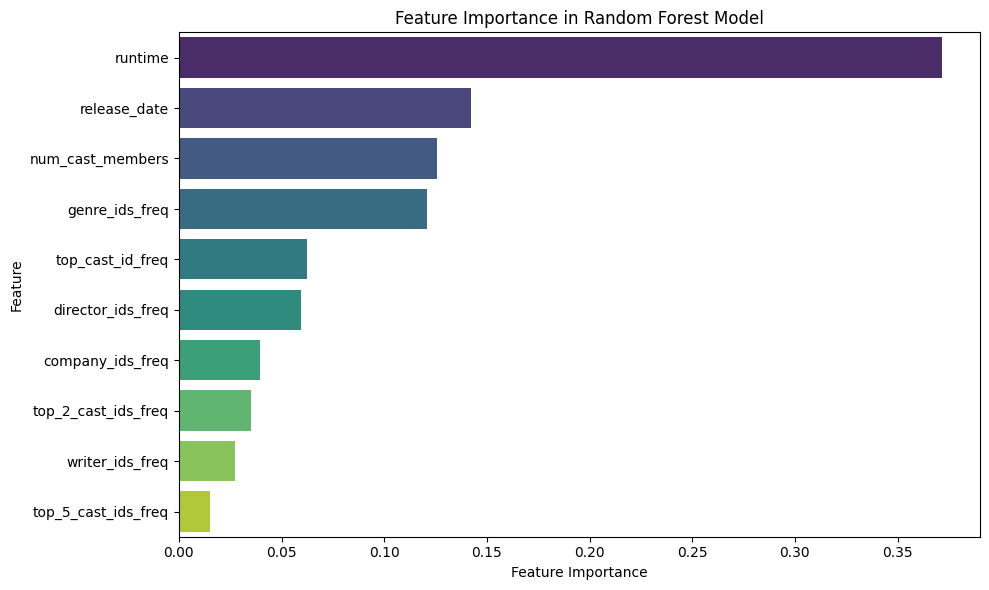

In [18]:
plot_feature_importance(rf, X_train.columns)

## Using the Model

Let's try the model out by predicting whether or not movies released during the current year will be successful. 

The data that we used to train and test the model restricted to movies with at least 30 votes so that we could be confident in each movies vote average. Of course, we would like to predict the success of movies before any votes have been cast. Thus, we first fetch all the movie data regardless of how many votes the movie has.

In [19]:
df_all = load_sql.fetch_movie_rating_features(min_votes=0)

Next, we filter to the movies with release dates matching the current year:

In [20]:
current_year = str(datetime.datetime.now().year)
new_movies = df_all[df_all['release_date'].str.startswith(current_year)]
new_movies.head()

,movie_id,vote_average,title,release_date,runtime,vote_count,top_cast_id,top_2_cast_ids,top_5_cast_ids,num_cast_members,director_ids,writer_ids,company_ids,genre_ids
56548,83533,0.0,Avatar: Fire and Ash,2025-12-17,0,0,65731,"65731,8691","65731,8691,10205,32747,204",24,2710,"507,2710,2710,2710,6039,67802,67802,67803,67803","574,127928","12,14,878"
140012,257094,0.0,Holland,2025-03-09,108,0,2227,"2227,258","2227,258,15576,1976054,3232669",10,1675644,1296509,"20859,32537,81755,84988,210099","18,53,9648"
155948,277171,0.0,Thingdom: El reino de las cosas,2025-12-31,86,0,150885,"150885,1331278","150885,1331278",2,232264,232264,None,None
156808,278201,0.0,Anpodu Kanmani,2025-01-24,0,0,1440952,"1440952,3276420","1440952,3276420,2037448,1855736,1696318",10,1734161,"1857798,4982162,4982162",240870,"18,10751"
158997,280951,3.0,Madha Gaja Raja,2025-01-12,142,1,559892,"559892,141076","559892,141076,1118770,123068,95750",19,584275,"19292,66563,584275,1301701,1543835,2225883",27024,"28,35,10749"


Before using the model to make predictions, we need to process the data of new movies:

In [21]:
new_movies = pre_split_processing(new_movies)
_, new_movies_encoded = add_frequency_encoding(train_df, new_movies, categorical_cols)
X_new_movies, _ = prepare_features(new_movies_encoded)

Now we can use the random forest model to make predictions

In [88]:
predictions = rf.predict(X_new_movies)
print(f"Number of movies predicted successful: {(predictions == 1).sum()}")
print(f"Number of movies predicted unsuccessful: {(predictions == 0).sum()}")
print(f"Proportion of movies predicted successful: {(predictions == 1).sum()/len(X_new_movies): .4f}")

Number of movies predicted successful: 59
Number of movies predicted unsuccessful: 2927
Proportion of movies predicted successful:  0.0198


As was the case with the test dataset, the model is predicting a low success rate for movies (still about 2%). 

In [23]:
probas = rf.predict_proba(X_new_movies)[:, 1]  # Probability of being 'Successful'
results_df = new_movies.copy()
results_df["Predicted Success"] = predictions
results_df["Success Probability"] = probas
results_df["Predicted Label"] = results_df["Predicted Success"].map({0: "Not Successful", 1: "Successful"})

In [24]:
top_preds = results_df.sort_values(by="Success Probability", ascending=False).head(10)
top_preds[["title", "Success Probability", "Predicted Label"]]

,title,Success Probability,Predicted Label
794446,The Queen of Heaven,0.616586,Successful
820529,Phantosmia,0.610524,Successful
881927,Cinextdoor presentéiert: Marginal,0.603900,Successful
871682,Bottle Radha,0.565062,Successful
850681,Cosmos,0.563530,Successful
867307,Margeado,0.557564,Successful
759316,All That’s Left of You,0.544993,Successful
792325,Four Quarters,0.541839,Successful
873943,Illti,0.541074,Successful
881858,Laaj Sharanam,0.541074,Successful


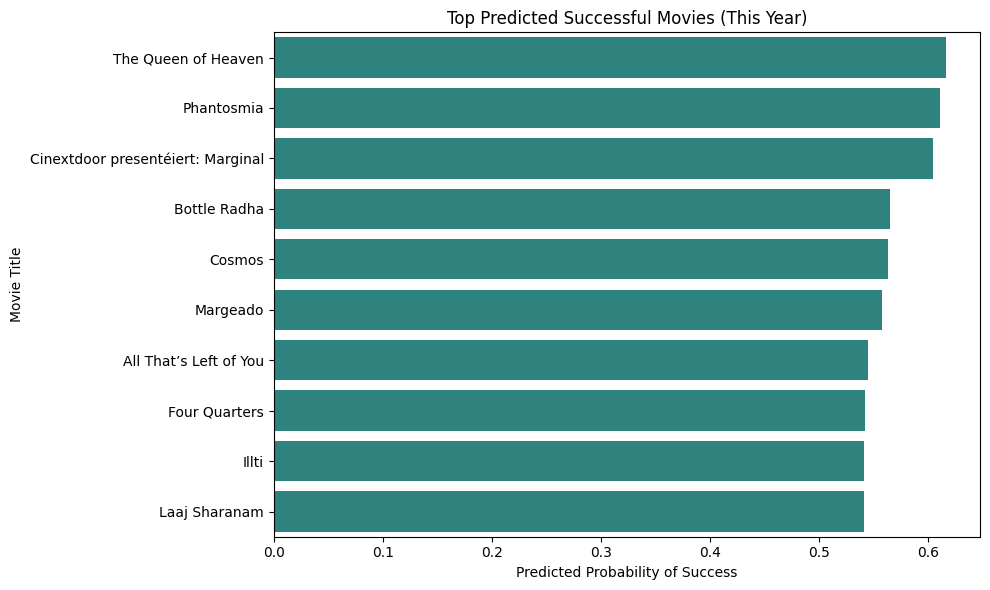

In [49]:
top_preds_plot = top_preds.sort_values(by="Success Probability", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_preds_plot,
    x="Success Probability",
    y="title",
    hue="Predicted Label",
    dodge=False,
    palette="viridis"
)
plt.title("Top Predicted Successful Movies (This Year)")
plt.xlabel("Predicted Probability of Success")
plt.ylabel("Movie Title")
plt.legend().remove()
plt.tight_layout()
plt.show()

## Can We Do Better? Predict Success using Categorical Scores

In [26]:
lambda_director   = 0.000408
lambda_writers    = 0.000377
lambda_cast_time  = 0.000592
lambda_cast_order = 0.122

df_with_scores = load_sql.fetch_predict_success_data(lambda_director, lambda_writers, lambda_cast_time, lambda_cast_order)
df_with_scores.head()

,movie_id,vote_average,title,release_date,runtime,vote_count,top_cast_id,top_2_cast_ids,top_5_cast_ids,num_cast_members,...,genre_Music,genre_Romance,genre_Family,genre_War,genre_TV Movie,director_score,writer_score,cast_score,production_company_score,successful
0,2,7.113,Ariel,593395200.0,73,341.0,None,None,None,0,...,0,1,0,0,0,6.292833,6.292833,6.292833,6.687600,1
1,3,7.300,Shadows in Paradise,529891200.0,74,404.0,None,None,None,0,...,0,1,0,0,0,6.292833,6.292833,6.292833,6.512667,1
2,5,5.858,Four Rooms,818467200.0,98,2674.0,3129,"3129,3130","3129,3130,3131,3124,2555",28,...,0,0,0,0,0,7.333995,7.355491,6.648418,6.302417,0
3,6,6.500,Judgment Night,750643200.0,109,345.0,2880,"2880,9777","2880,9777,5724,10822,12799",31,...,0,0,0,0,0,5.882887,6.119896,6.370170,6.376285,0
4,11,8.200,Star Wars,233366400.0,121,20915.0,2,"2,3","2,3,4,5,12248",104,...,0,0,0,0,0,6.782933,6.676182,6.170755,6.623217,1


In [56]:
train_df_with_scores, test_df_with_scores = train_test_split(df_with_scores, test_size=0.2, random_state=42)

In [57]:
train_df_with_scores, test_df_with_scores = add_frequency_encoding(train_df_with_scores, test_df_with_scores, categorical_cols)
X_train_with_scores, y_train_with_scores = prepare_features(train_df_with_scores)
X_test_with_scores, y_test_with_scores = prepare_features(test_df_with_scores)

In [64]:
rf_with_scores = RandomForestClassifier(
    n_estimators=200,
    max_depth=10, 
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    bootstrap=True,
    oob_score=True,
    random_state=42
)

rf_with_scores.fit(X_train_with_scores, y_train_with_scores)

print("Training score:", rf_with_scores.score(X_train_with_scores, y_train_with_scores))
print("Testing score:", rf_with_scores.score(X_test_with_scores, y_test_with_scores))

Training score: 0.8286211640508746
Testing score: 0.8117911285794498


In [84]:
pred_with_scores = rf_with_scores.predict(X_test_with_scores)
print(f"Total number of movies in test set: {len(X_test_with_scores)}")
print(f"Total number of successful movies in test set: {y_test_with_scores.sum()}")
print(f"Number of movies in test set predicted successful: {pred_with_scores.sum()}")

Total number of movies in test set: 8905
Total number of successful movies in test set: 1843
Number of movies in test set predicted successful: 409


In [85]:
print(f"Precision: {precision_score(y_test, pred): .2f} (probability that a predicted success is actually successful)")
print(f"Recall:    {recall_score(y_test, pred): .2f} (probability that an actual success is predicted successful)")

Precision:  0.59 (probability that a predicted success is actually successful)
Recall:     0.07 (probability that an actual success is predicted successful)


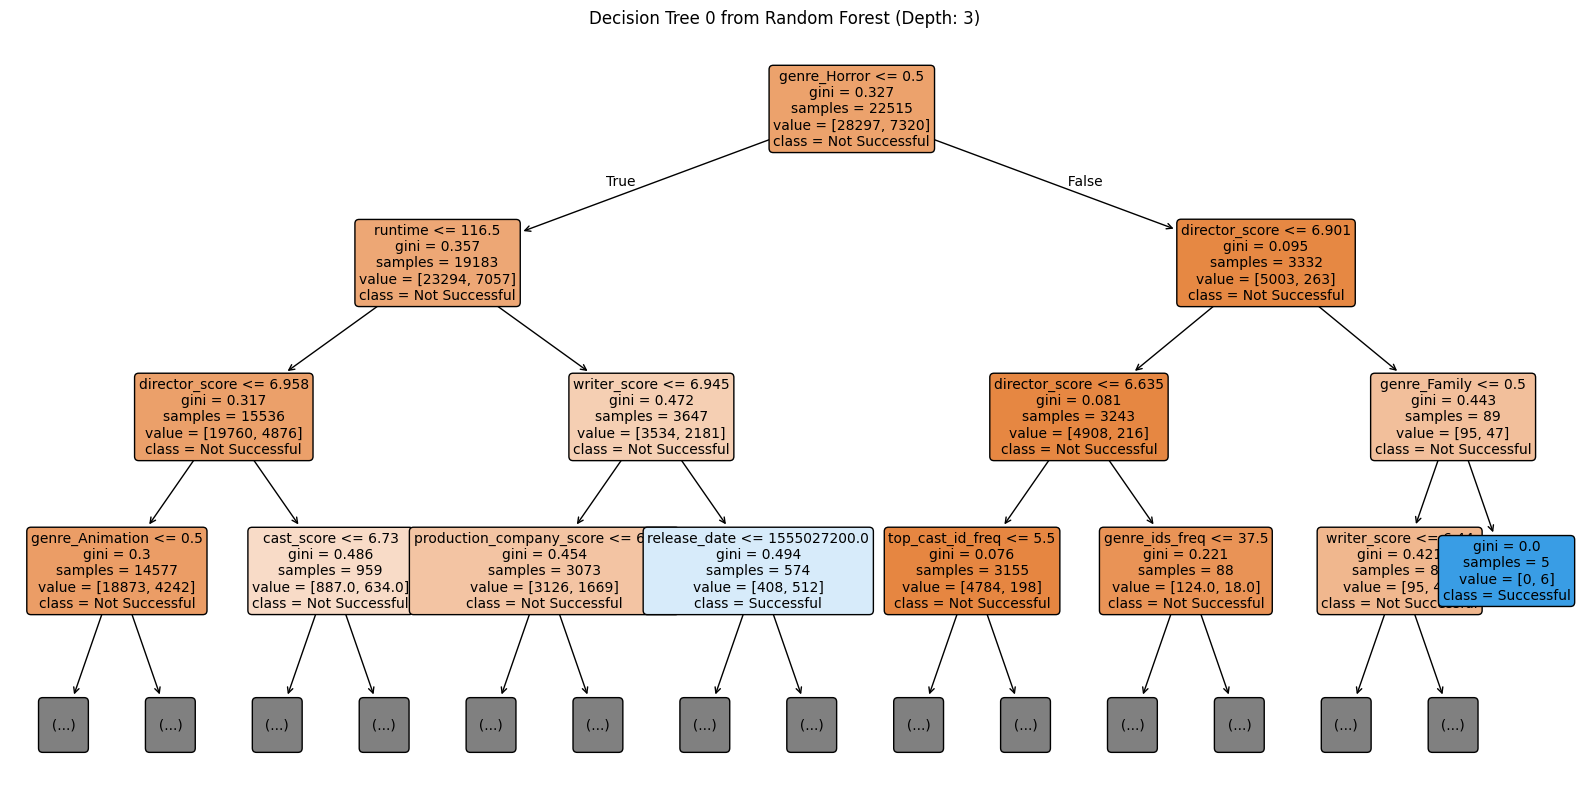

In [65]:
plot_random_forest_tree(rf_with_scores, feature_names=X_train_with_scores.columns, tree_index=0, max_depth=3)

In [66]:
get_feature_importance_df(rf_with_scores, X_train_with_scores.columns).head()

,Feature,Importance
25,production_company_score,0.191623
1,runtime,0.127911
24,cast_score,0.111789
22,director_score,0.080257
14,genre_Documentary,0.078945


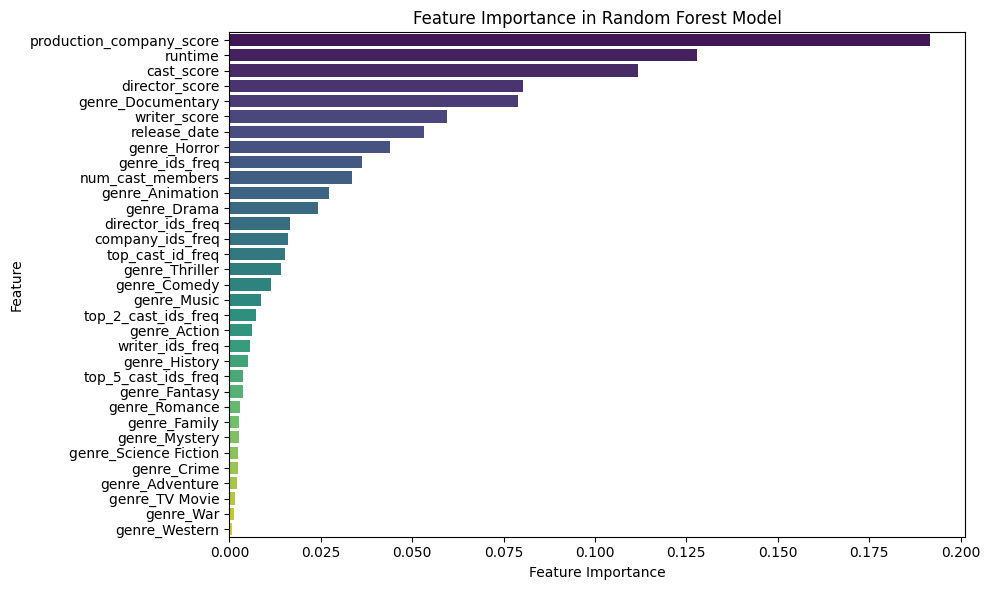

In [67]:
plot_feature_importance(rf_with_scores, X_train_with_scores.columns)